In [10]:
import pylab
import sys
import pymzml
import numpy as np
import pickle
import os



In [ ]:
for parent in ["POS","NEG"]:
    for filename in os.listdir(f"../../data/{parent}"):
        # remove exsiting pickle files
        if filename[-4:] == ".pkl":
            os.remove(f"../../data/{parent}/{filename}")
            continue
        filename = f"../../data/{parent}/{filename}"
        run = pymzml.run.Reader(filename, build_index_from_scratch = True)
        TIC = []
        for i, spec in enumerate(run):
            mz = spec.peaks("raw")
            TIC.append(np.max(mz))
        TIC = np.convolve(TIC, np.ones(20)/20, mode='same')
        TIC2 = np.interp(np.linspace(0,len(TIC),2400), np.arange(len(TIC)), TIC)
        # save TIC into a pickle file filename.pkl
        with open(filename+".pkl", "wb") as f:
            pickle.dump(TIC2, f)

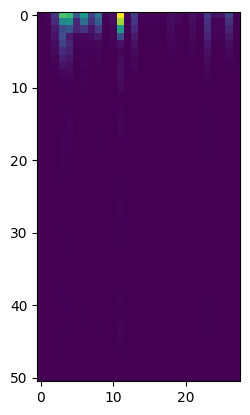

In [88]:
import scipy.signal
import pylab

f, t, Zxx = scipy.signal.stft(TIC[0], nperseg=100, noverlap=10)
amp = 2 * np.sqrt(2)
# pylab.pcolormesh(t, f, np.log10(np.abs(Zxx))/10, vmin=0, vmax=amp, shading='gouraud')
pylab.imshow(np.abs(Zxx)/np.max(np.abs(Zxx)))

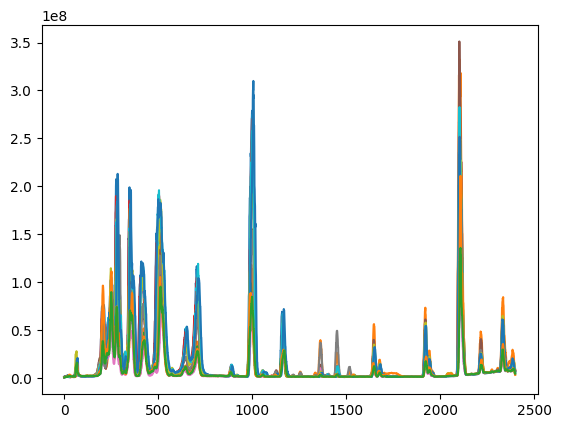

In [2]:
# visluze all POS in one plot
pylab.figure()
for filename in os.listdir(f"../../data/POS"):
    # ignore KB started file
    if filename[:2] == "KB":
        continue
    if filename[-4:] == ".pkl":
        with open(f"../../data/POS/{filename}", "rb") as f:
            TIC = pickle.load(f)
        pylab.plot(TIC)
pylab.show()

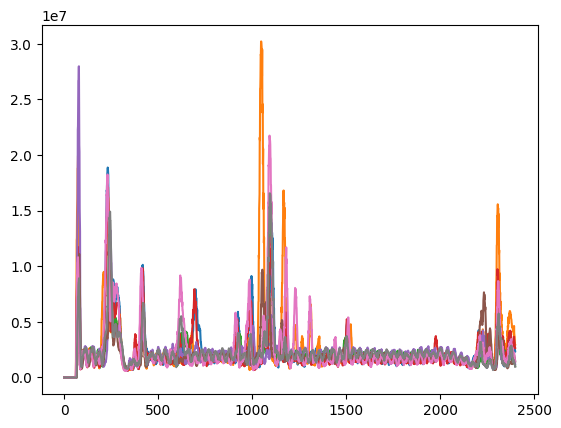

In [3]:
# visulize all NEG in one plot
pylab.figure()
for filename in os.listdir(f"../../data/NEG"):
    if filename[:2] == "KB":
        continue
    if filename[-4:] == ".pkl":
        with open(f"../../data/NEG/{filename}", "rb") as f:
            TIC = pickle.load(f)
        pylab.plot(TIC)

In [103]:

import torch.nn as nn
import json
import torch 

with open("../../config.json","r") as f:
    config = json.load(f)
config["BS"] = 1
# config["K"] = 64


In [108]:
import sys
sys.path.append("../../")
# config["N"] = 8
config["dim"] = 128
import moco.builder
model = moco.builder.MoCo(
    BaseModel,
    config["K"],
    65536,
    0.99,
    0.08, 
    True,
)
model = model.train(True)
model = torch.nn.DataParallel(model)
mod = torch.load("../../checkpoint_0008.pth.tar")
# mod = torch.load("../../checkpoint_0001.pth.tar")
model.load_state_dict(mod["state_dict"]) 

model = model.module.encoder_q
# model.pred = nn.Identity()

In [36]:
# state_dict = model.state_dict()
# for key in state_dict:
#     state_dict[key] = torch.randn_like(state_dict[key], dtype=torch.float32).to(state_dict[key].dtype)
# model.load_state_dict(state_dict)  

<All keys matched successfully>

In [109]:
# use the model to encode each TIC and save embeding into x and y
x = []
y = []
model = model.eval()
model = model.cuda()
for parent in ["POS","NEG"]: 
    for filename in os.listdir(f"../../data/{parent}"):
        if filename[-4:] != ".pkl":
            continue
        with open(f"../../data/{parent}/{filename}", "rb") as f:
            TIC = pickle.load(f)
        TIC = torch.tensor(TIC).unsqueeze(0).float()
        output = model(TIC.cuda())
        x.append(output.detach().cpu().numpy().squeeze(0))
        y.append(1 if parent=="POS" else 0)


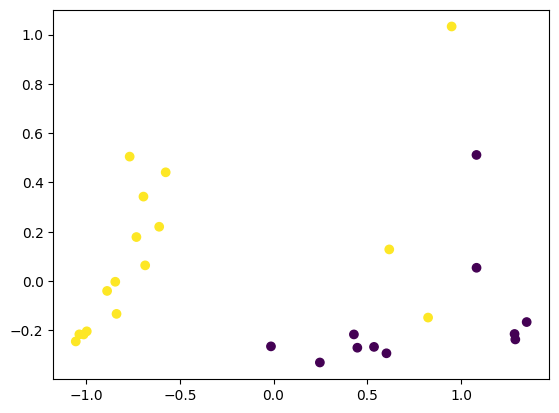

In [110]:
# show PCA of the embeding and color by POS or NEG
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
x = np.array(x)
x2 = pca.fit_transform(x)
pylab.scatter(x2[:,0], x2[:,1], c=y)


0.8888888888888888
0.8888888888888888
0.8518518518518519
0.8518518518518519
0.8518518518518519
0.8888888888888888
0.8888888888888888
0.8888888888888888
0.8888888888888888


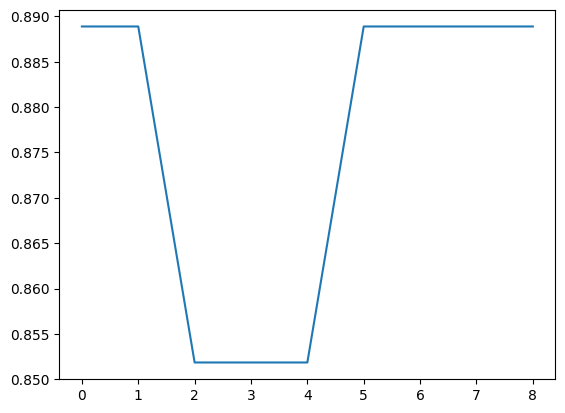

In [111]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

n = len(x)
x = np.array(x)
y = np.array(y)
ans = []
for k in range(1,10):
    svm_sum = 0
    lr_rum= 0
    knn_sum = 0
    for train_index, test_index in KFold(n_splits=n, shuffle=True).split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]ms.ipynb
        clf1 = SVC().fit(x_train, y_train)
        clf2 = LogisticRegression(random_state=0).fit(x_train, y_train)
        clf3 = KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
        y_pred = clf1.predict(x_test)
        svm_sum+=(accuracy_score(y_test, y_pred))
        
        y_pred = clf2.predict(x_test)
        lr_rum+=(accuracy_score(y_test, y_pred))
        
        y_pred = clf3.predict(x_test)
        knn_sum+=(accuracy_score(y_test, y_pred))
        
    print(knn_sum/n)
    ans.append(knn_sum/n)
pylab.plot(ans)